In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite as bp
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action='once')

import plotly.express as px

## Extracting Data

In [2]:
df = pd.read_csv('us_media_ownership.csv', encoding_errors='ignore')

In [3]:
df.head()

,Main Stream Media,Top Investor,%,Top Donor,Owner,Owner Type,Medium,Reach,Est. Monthly
0,Wikipedia,Google,NaN,Arcadia,NaN,Non Profit,Digital Only,5B,1700000000
1,Wikipedia,WojcickiFoundation (YouTube),NaN,Google Org,NaN,Non Profit,Digital Only,5B,1700000000
2,Wikipedia,-,NaN,Amazon,NaN,Non Profit,Digital Only,5B,1700000000
3,Wikipedia,-,NaN,Musk Fundation,NaN,Non Profit,Digital Only,5B,1700000000
4,Wikipedia,-,NaN,Facebook,NaN,Non Profit,Digital Only,5B,1700000000


## Create Network Graph

In [4]:
# create a graph
df['Top Investor'] = df['Top Investor'].str.replace('.','').str.replace(',','').str.strip()

edges = [tuple(x) for x in df[['Main Stream Media', 'Top Investor', 'Est. Monthly']].values.tolist()]

G = nx.Graph()
G.add_nodes_from(df['Main Stream Media'].unique(), bipartite=0, label='Main Stream Media', edge_attr=True)
G.add_nodes_from(df['Top Investor'].replace(['.','.'],'').str.strip().unique(), bipartite=1, label='Top Investor', edge_attr=True)

for row in edges:
    G.add_edge(row[0], row[1], monthly_est=row[2])

edge_list = nx.to_edgelist(G)

C:\Users\DIEGOC~1\AppData\Local\Temp/ipykernel_5456/605682384.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Top Investor'] = df['Top Investor'].str.replace('.','').str.replace(',','').str.strip()


In [5]:
print(nx.is_connected(G))

False


### Visualizing Network

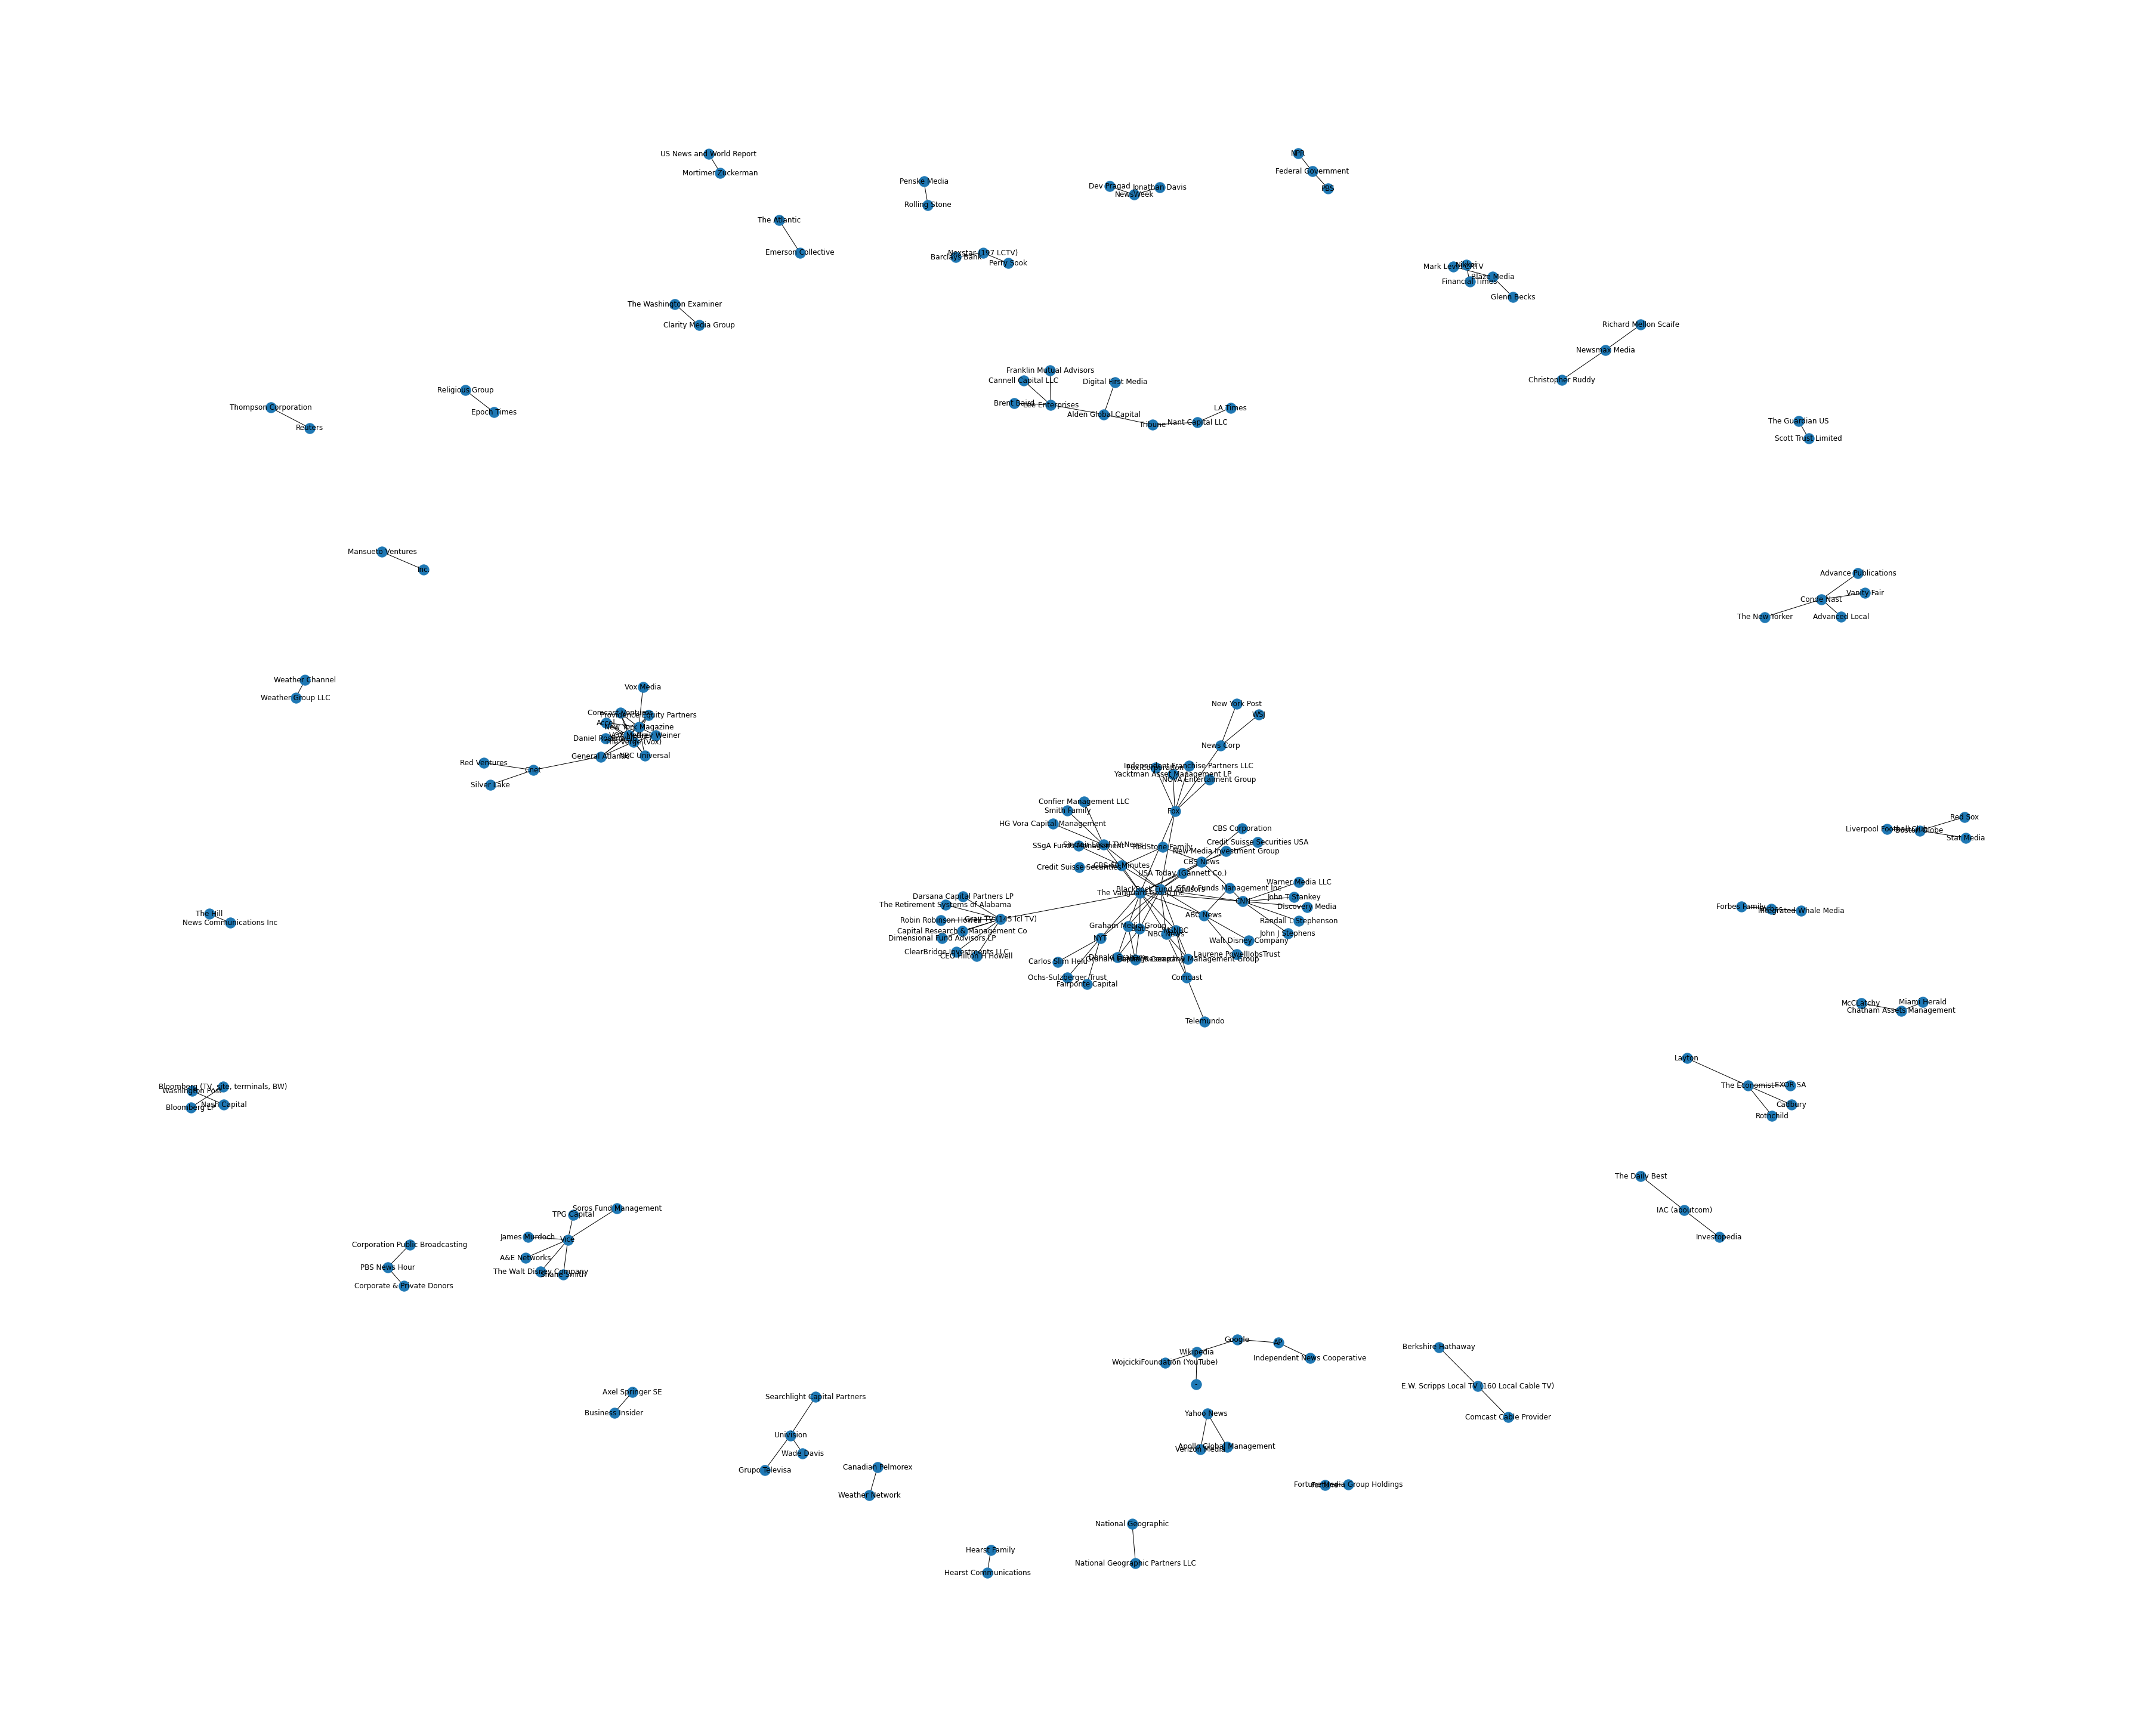

In [6]:
# First look at the graph

plt.figure(figsize=(50,40))
nx.draw(G, with_labels=True)


### Finding the largest subgraph in the disconnected network

In [7]:
# Find subgraphs
connected_subgraphs = [G.subgraph(cc).copy() for cc in nx.connected_components(G)]

# Find the largest subgraph
SG = max(nx.connected_components(G), key=len)
SG = G.subgraph(SG)

n = [n for n,d in SG.nodes(data=True) if len(d) == 0]


In [8]:
print(nx.is_connected(SG))

True


In [9]:
print(nx.is_bipartite(SG))

True


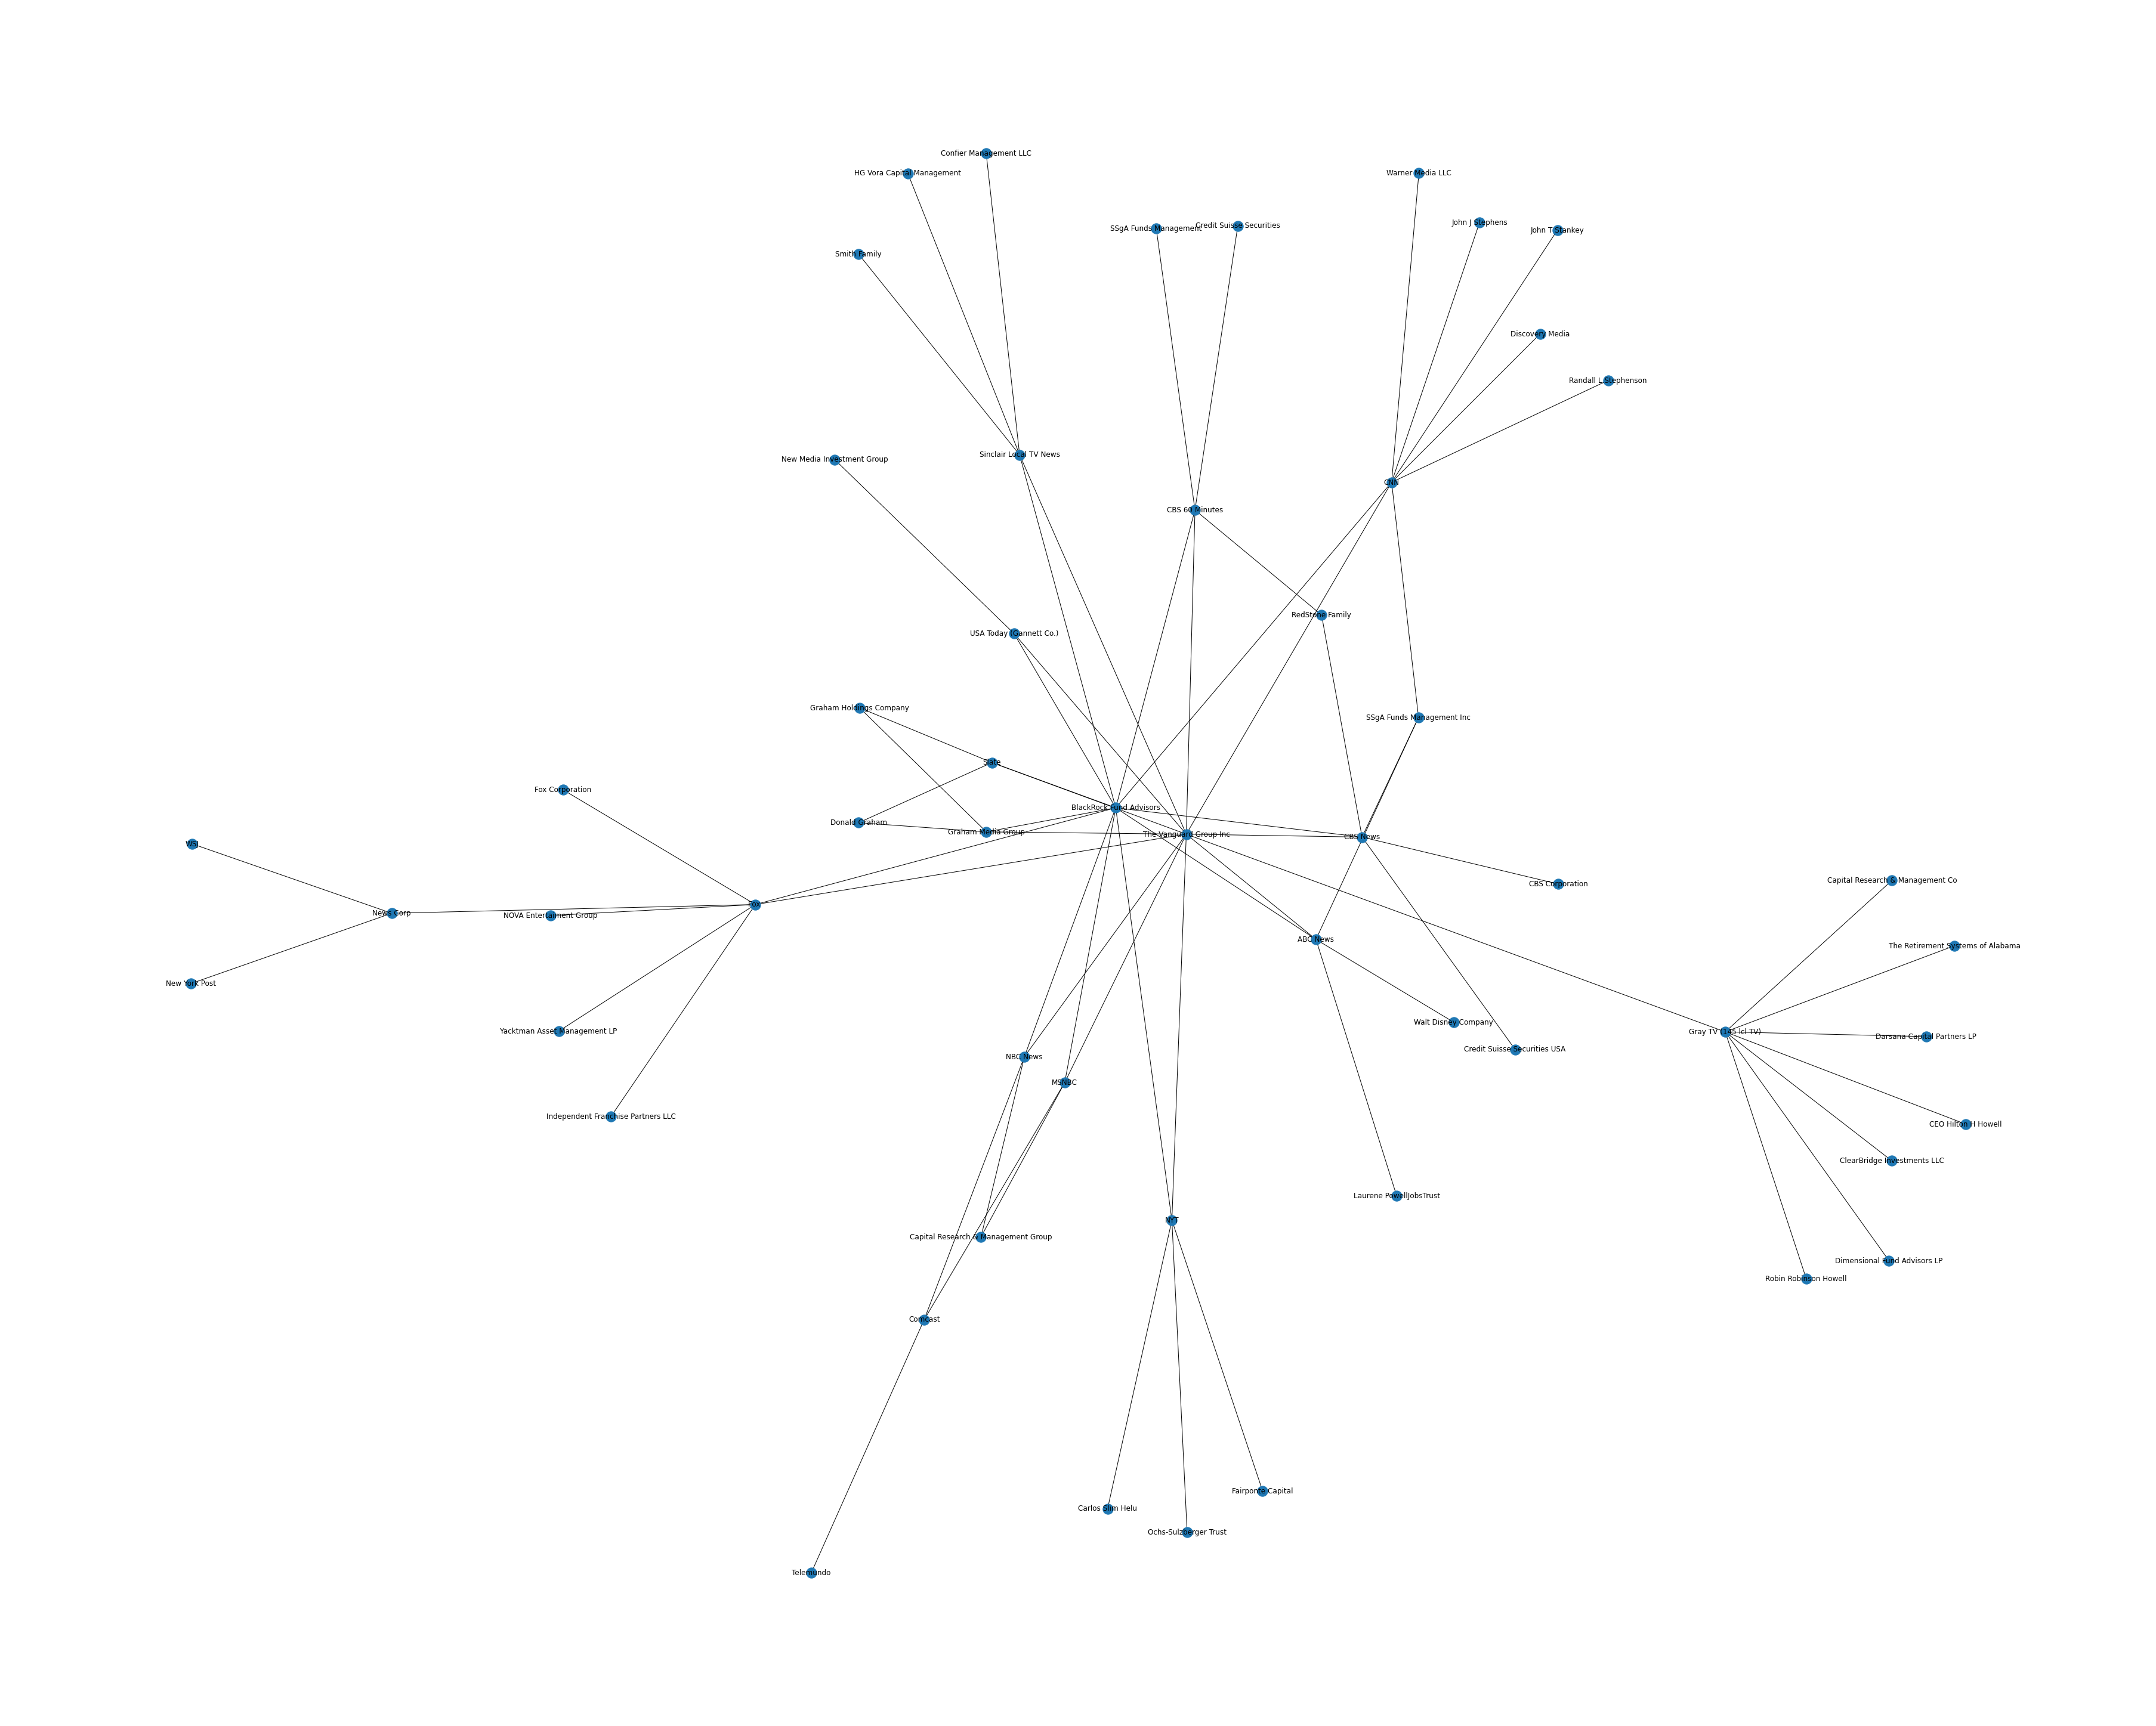

In [10]:
plt.figure(figsize=(50,40))
nx.draw(SG, with_labels=True)

### Assinging nodes into sets

In [11]:
bottom_nodes, top_nodes = bp.sets(SG)

top_nodes = {n for n, d in SG.nodes(data=True) if len(d) > 0 and d['bipartite'] == 0}
bottom_nodes = set(SG) - top_nodes

# Media set
print(list(top_nodes))

['ABC News', 'New York Post', 'CBS 60 Minutes', 'WSJ', 'CBS News', 'CNN', 'MSNBC', 'Telemundo', 'USA Today (Gannett Co.)', 'Slate', 'Graham Media Group', 'Sinclair Local TV News', 'NBC News', 'NYT', 'Gray TV (145 lcl TV)', 'Fox ']


In [12]:
# Investors set
print(list(bottom_nodes))

['The Retirement Systems of Alabama', 'Smith Family', 'Darsana Capital Partners LP', 'Randall L Stephenson', 'John J Stephens', 'BlackRock Fund Advisors', 'Walt Disney Company', 'Confier Management LLC', 'CBS Corporation', 'New Media Investment Group', 'Credit Suisse Securities USA', 'SSgA Funds Management Inc', 'Donald Graham', 'Ochs-Sulzberger Trust', 'News Corp', 'Capital Research & Management Co', 'Carlos Slim Helu', 'Comcast', 'HG Vora Capital Management', 'Independent Franchise Partners LLC', 'SSgA Funds Management', 'Dimensional Fund Advisors LP', 'Graham Holdings Company', 'Fox Corporation', 'Warner Media LLC', 'Credit Suisse Securities', 'Discovery Media', 'John T Stankey', 'Fairponte Capital', 'NOVA Entertaiment Group', 'Yacktman Asset Management LP', 'Laurene PowellJobsTrust', 'RedStone Family', 'CEO Hilton H Howell', 'Capital Research & Management Group', 'Robin Robinson Howell', 'The Vanguard Group Inc', 'ClearBridge Investments LLC']


In [13]:
pos = dict()
color = []
pos.update( (n, (1, i)) for i, n in enumerate(bottom_nodes) )
pos.update( (n, (2, i)) for i, n in enumerate(top_nodes) )

### Visualizing Bipartite Network

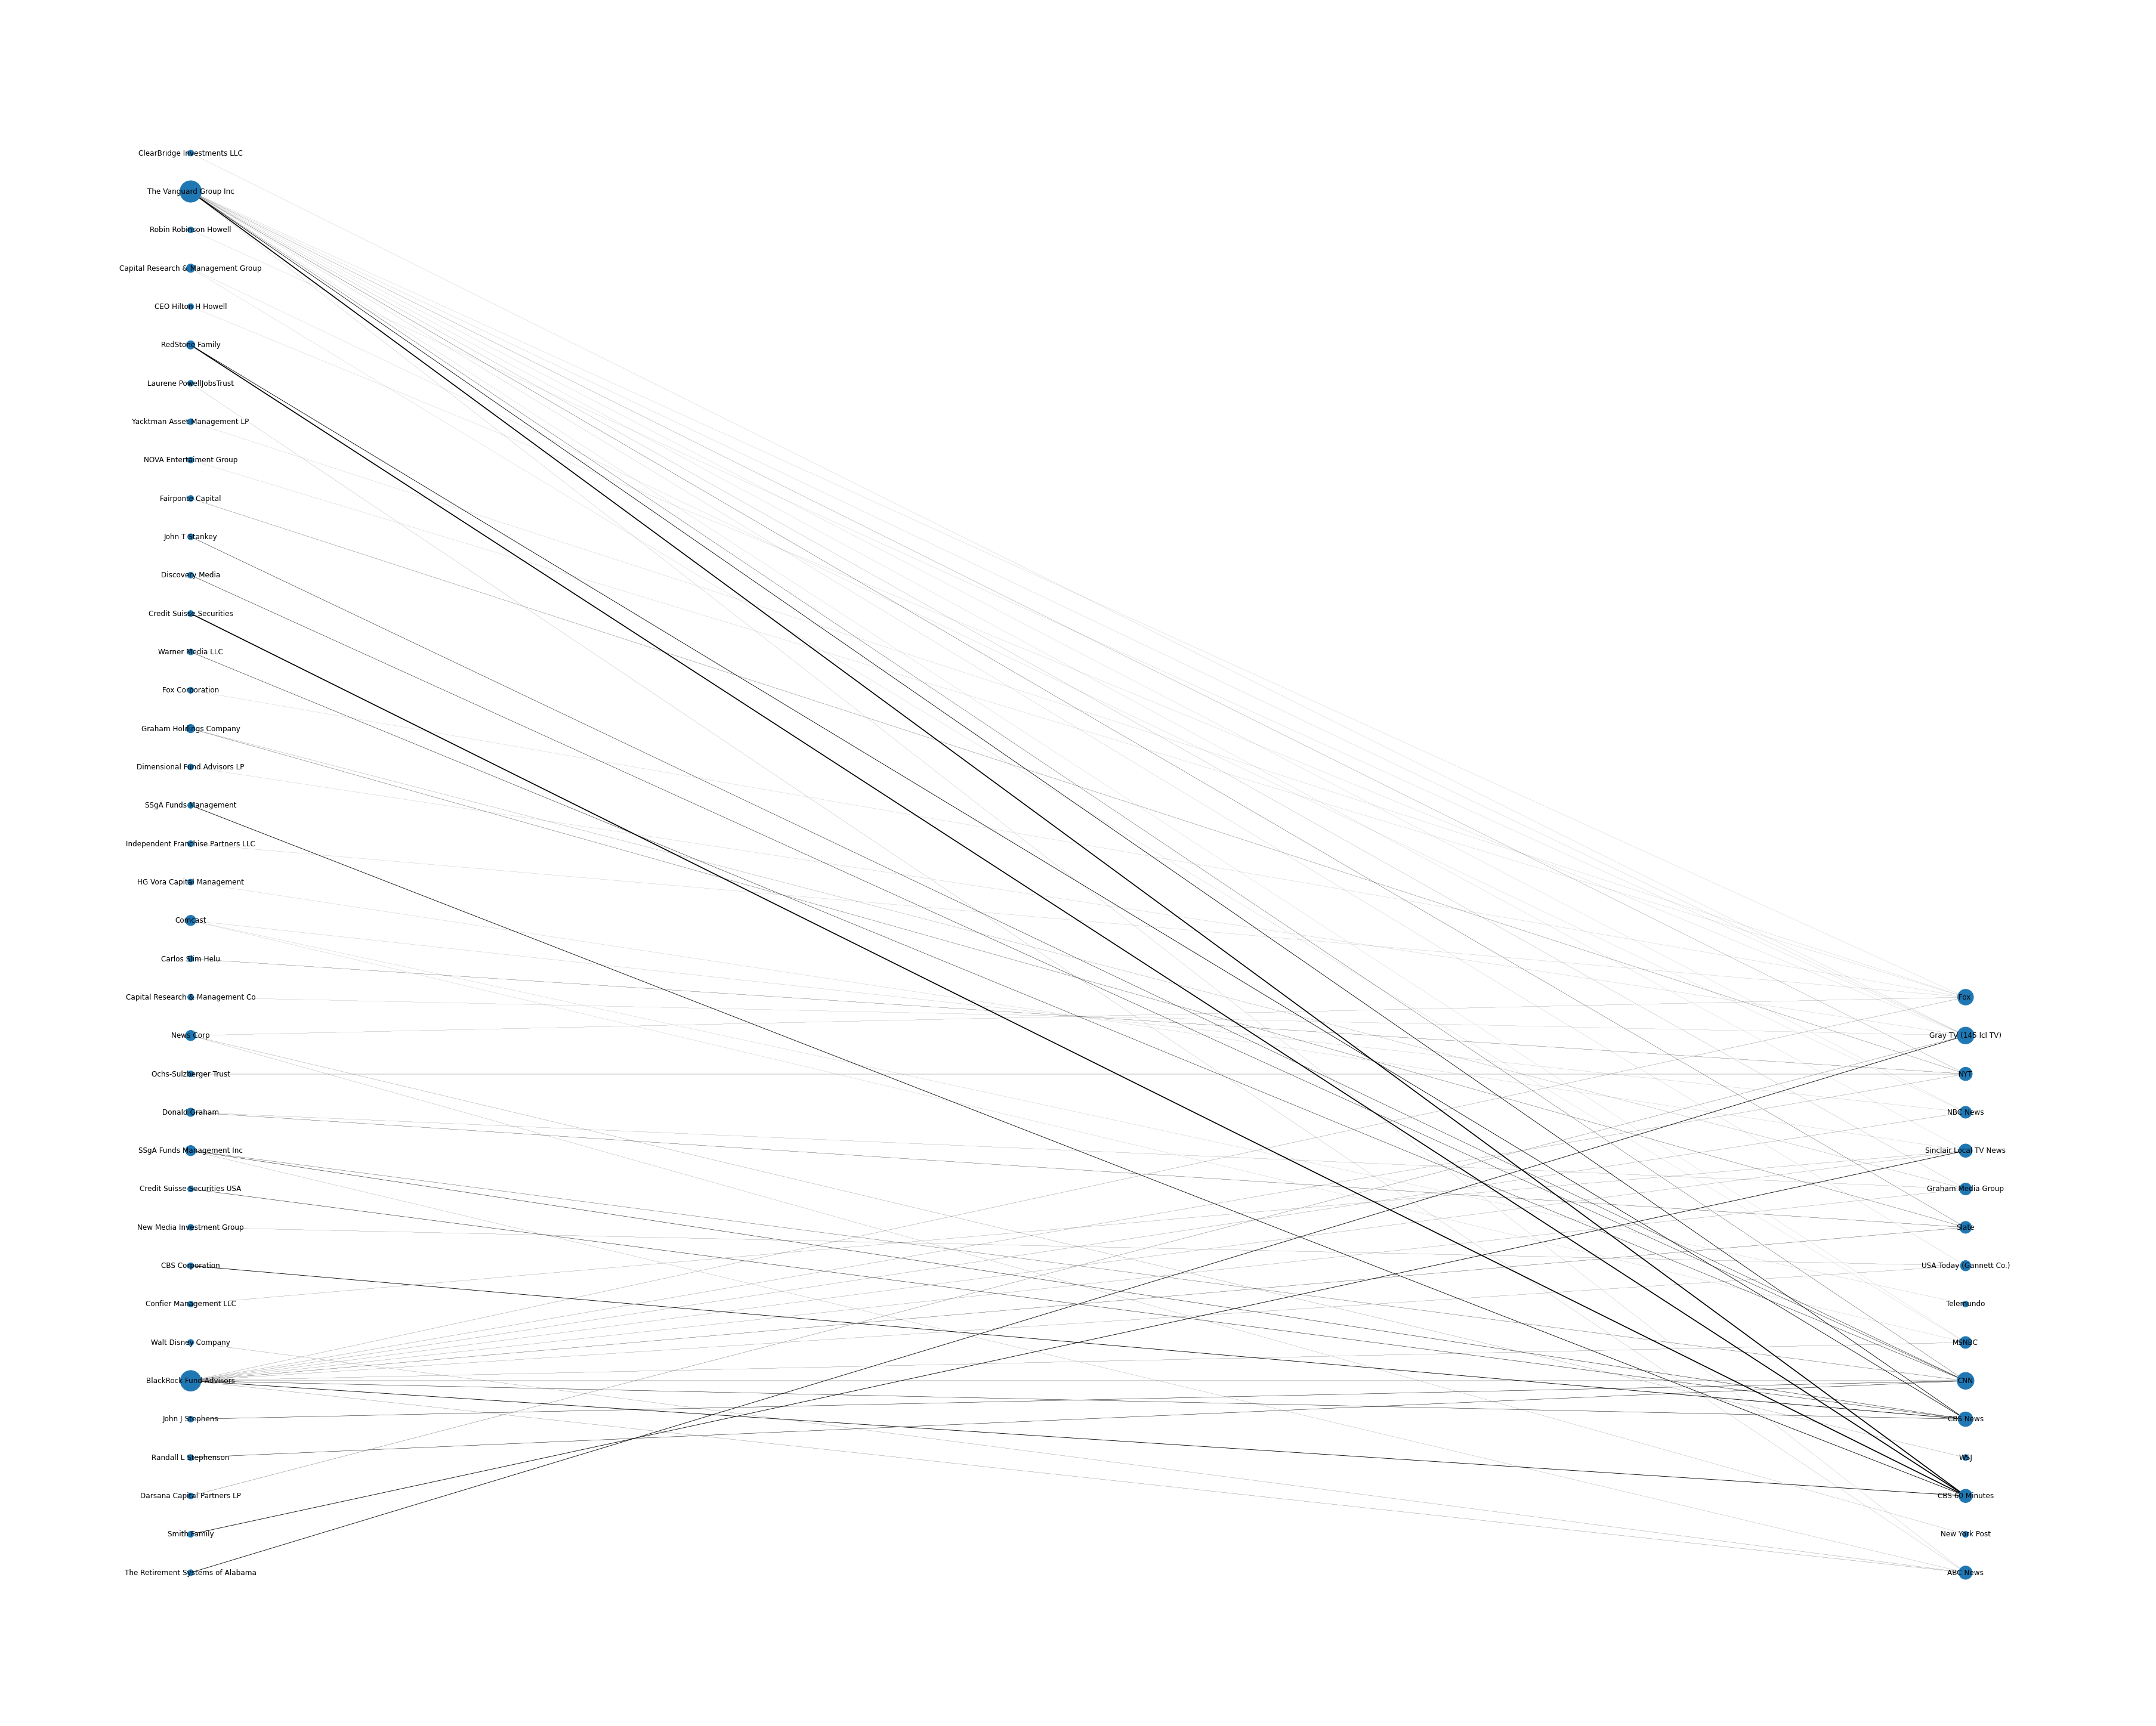

In [24]:
plt.figure(figsize=(50,40))
nx.draw(SG, pos=pos,
        with_labels=True,
        # node_color = color_list,
        node_size = [v * 100 for v in dict(SG.degree()).values()],
        width = [v[2]['monthly_est']/1_000_000_000 for v in edge_list])
        
plt.show()

## Projected Bipartite Graph

In [25]:
# Projected Graphs

media_graph = bp.projected_graph(SG, top_nodes)
investor_graph = bp.projected_graph(SG, bottom_nodes)


### Main Stream Media

In [16]:
# Betweeness
bc = nx.betweenness_centrality(media_graph)
df_bc = pd.DataFrame.from_dict({
        'node': list(bc.keys()),
        'betweeness': list(bc.values())
})
df_bc.sort_values('betweeness', ascending=False)

# Closeness
cc = nx.closeness_centrality(media_graph)
df_cc = pd.DataFrame.from_dict({
        'node': list(cc.keys()),
        'closeness': list(cc.values())
})
df_cc.sort_values('closeness', ascending=True)

# Degree Centrality
dc = nx.degree_centrality(media_graph)
df_dc = pd.DataFrame.from_dict({
        'node': list(dc.keys()),
        'degree': list(dc.values())
})
df_dc.sort_values('degree', ascending=False)

summary_df = df_dc.merge(df_cc).merge(df_bc)
summary_df.sort_values(by=['degree','closeness'], ascending=False)

,node,degree,closeness,betweeness
15,Fox,0.933333,0.937500,0.247619
6,MSNBC,0.866667,0.882353,0.061905
12,NBC News,0.866667,0.882353,0.061905
0,ABC News,0.800000,0.833333,0.000000
2,CBS 60 Minutes,0.800000,0.833333,0.000000
4,CBS News,0.800000,0.833333,0.000000
5,CNN,0.800000,0.833333,0.000000
8,USA Today (Gannett Co.),0.800000,0.833333,0.000000
9,Slate,0.800000,0.833333,0.000000
10,Graham Media Group,0.800000,0.833333,0.000000


In [17]:
melt = summary_df.melt(id_vars=['node'], value_vars=['degree','betweeness','closeness'])

fig = px.line(melt, x='node', y='value', color='variable')
fig.show()

### Top Investors

In [18]:
# Betweeness
bc = nx.betweenness_centrality(investor_graph)
df_bc = pd.DataFrame.from_dict({
        'node': list(bc.keys()),
        'betweeness': list(bc.values())
})
df_bc.sort_values('betweeness', ascending=False)

# Closeness
cc = nx.closeness_centrality(investor_graph)
df_cc = pd.DataFrame.from_dict({
        'node': list(cc.keys()),
        'closeness': list(cc.values())
})
df_cc.sort_values('closeness', ascending=True)

# Degree Centrality
dc = nx.degree_centrality(investor_graph)
df_dc = pd.DataFrame.from_dict({
        'node': list(dc.keys()),
        'degree': list(dc.values())
})
df_dc.sort_values('degree', ascending=False)

summary_df = df_dc.merge(df_cc).merge(df_bc)
summary_df.sort_values(by=['degree','closeness'], ascending=False)

,node,degree,closeness,betweeness
36,The Vanguard Group Inc,1.000000,1.000000,0.577077
5,BlackRock Fund Advisors,0.810811,0.840909,0.261762
11,SSgA Funds Management Inc,0.324324,0.596774,0.015516
0,The Retirement Systems of Alabama,0.189189,0.552239,0.000000
2,Darsana Capital Partners LP,0.189189,0.552239,0.000000
3,Randall L Stephenson,0.189189,0.552239,0.000000
4,John J Stephens,0.189189,0.552239,0.000000
15,Capital Research & Management Co,0.189189,0.552239,0.000000
21,Dimensional Fund Advisors LP,0.189189,0.552239,0.000000
24,Warner Media LLC,0.189189,0.552239,0.000000


In [19]:
melt = summary_df.melt(id_vars=['node'], value_vars=['degree','betweeness','closeness'])

fig = px.line(melt, x='node', y='value', color='variable')
fig.show()

## Projected Weighted Graphs

### Main Stream Media

In [20]:
# Weighted projection on media nodes

weighted_media_graph = bp.weighted_projected_graph(SG, top_nodes, ratio=False)

weight_list = list(weighted_media_graph.edges(data=True))
weight_df = pd.DataFrame.from_records(weight_list, columns=['comp1', 'comp2', 'weight'])

weights = weight_df['weight'].tolist()
w = pd.DataFrame(weights)

weight_df.drop('weight', axis=1, inplace=True)
weight_df = weight_df.assign(weight=w['weight'])

weight_df.sort_values('weight', ascending=True)
# weight_df

,comp1,comp2,weight
82,Gray TV (145 lcl TV),Fox,1
45,MSNBC,Telemundo,1
34,CBS News,Gray TV (145 lcl TV),1
52,MSNBC,Gray TV (145 lcl TV),1
54,Telemundo,NBC News,1
...,...,...,...
27,CBS News,CNN,3
3,ABC News,CNN,3
2,ABC News,CBS News,3
50,MSNBC,NBC News,4


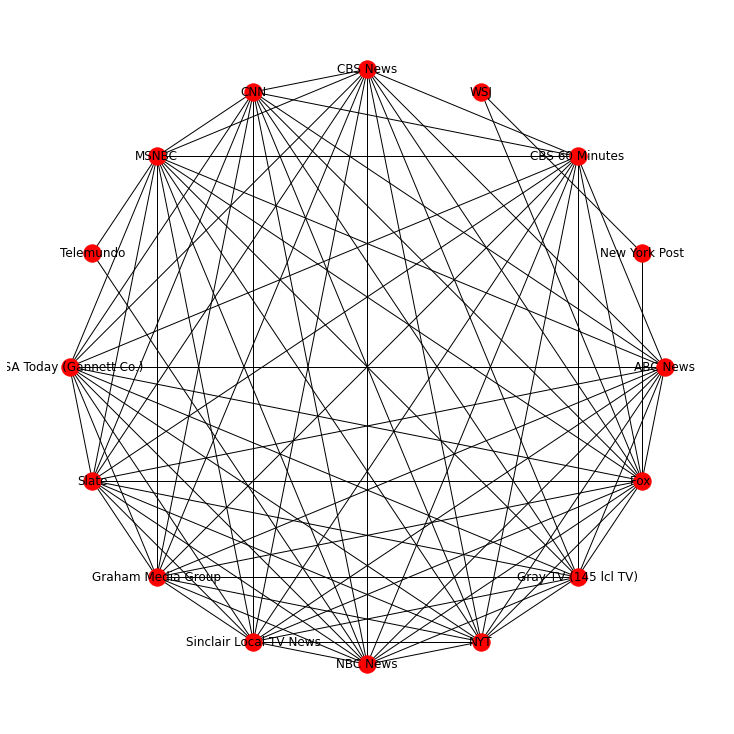

In [21]:
plt.figure(figsize=(10,10))
nx.draw_circular(weighted_media_graph, node_color='r', with_labels=True)

### Top Investors

In [22]:
# Weighted projection on investors nodes

weighted_investors_graph = bp.weighted_projected_graph(SG, bottom_nodes, ratio=False)

weight_list = list(weighted_investors_graph.edges(data=True))
weight_df = pd.DataFrame.from_records(weight_list, columns=['comp1', 'comp2', 'weight'])

weights = weight_df['weight'].tolist()
w = pd.DataFrame(weights)

weight_df.drop('weight', axis=1, inplace=True)
weight_df = weight_df.assign(weight=w['weight'])

weight_df.sort_values('weight', ascending=True)
# weight_df

,comp1,comp2,weight
0,The Retirement Systems of Alabama,Capital Research & Management Co,1
95,HG Vora Capital Management,The Vanguard Group Inc,1
92,Carlos Slim Helu,The Vanguard Group Inc,1
91,Carlos Slim Helu,Fairponte Capital,1
90,Capital Research & Management Co,ClearBridge Investments LLC,1
...,...,...,...
52,BlackRock Fund Advisors,Donald Graham,2
31,BlackRock Fund Advisors,Comcast,2
51,BlackRock Fund Advisors,SSgA Funds Management Inc,3
75,SSgA Funds Management Inc,The Vanguard Group Inc,3


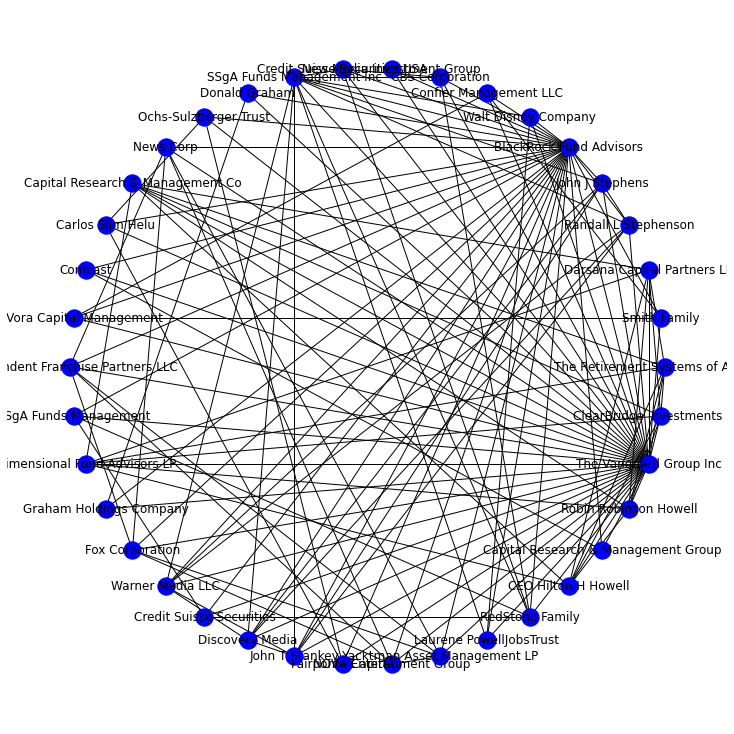

In [23]:
plt.figure(figsize=(10,10))
nx.draw_circular(weighted_investors_graph, node_color='b', with_labels=True)